# Import Lib

In [1]:
import os
# 0 = all logs, 1 = filter out INFO, 2 = filter out WARNING, 3 = filter out ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf

2025-05-14 21:30:50.542205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747258251.045293      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747258251.247668      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# --- 1. GPU config ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.debugging.set_log_device_placement(False)
else:
    print("No GPU found!")

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# Load Data

In [6]:
# Path to the directory you want to check
folder_path = '/kaggle/input/coco-image-caption/train2014/train2014'

# List of file names in the directory
file_list = os.listdir(folder_path)
# Count the number of files
num_files = len(file_list)

print(f"There are {num_files} files in the directory {folder_path}")

There are 82783 files in the directory /kaggle/input/coco-image-caption/train2014/train2014


In [7]:
image_folder_path = '/kaggle/input/coco-image-caption/train2014/train2014'
caption_folder_path = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations'

In [8]:
captions_train = []
caption_file_path = os.path.join(caption_folder_path, 'captions_train2014.json')

with open(caption_file_path, 'r') as file:
    captions_train = json.load(file)

In [9]:
file_names = []
image_ids = []
captions = []

annotations = captions_train['annotations']
images=captions_train['images']

# Create a dictionary to map image_id to file_name
image_id_to_filename = {image['id']: image['file_name'] for image in images}

# Initialize empty lists to store the data
image_ids = []
captions = []
file_names = []

# Loop through the list of annotations
for annotation in annotations:
    image_id = annotation['image_id']
    if image_id in image_id_to_filename:
        file_name = "/kaggle/input/coco-image-caption/train2014/train2014/" + image_id_to_filename[image_id]
        image_ids.append(image_id)
        captions.append(annotation['caption'])
        file_names.append(file_name)

# Create a pandas DataFrame using the extracted data
data_train = {
    'image_id': image_ids,
    'image': file_names,
    'caption': captions

}

data_train = pd.DataFrame(data_train)

In [10]:
data_train

,image_id,image,caption
0,318556,/kaggle/input/coco-image-caption/train2014/tra...,A very clean and well decorated empty bathroom
1,116100,/kaggle/input/coco-image-caption/train2014/tra...,A panoramic view of a kitchen and all of its a...
2,318556,/kaggle/input/coco-image-caption/train2014/tra...,A blue and white bathroom with butterfly theme...
3,116100,/kaggle/input/coco-image-caption/train2014/tra...,A panoramic photo of a kitchen and dining room
4,379340,/kaggle/input/coco-image-caption/train2014/tra...,A graffiti-ed stop sign across the street from...
...,...,...,...
414108,133071,/kaggle/input/coco-image-caption/train2014/tra...,a slice of bread is covered with a sour cream ...
414109,410182,/kaggle/input/coco-image-caption/train2014/tra...,A long plate hold some fries with some sliders...
414110,180285,/kaggle/input/coco-image-caption/train2014/tra...,Two women sit and pose with stuffed animals.
414111,133071,/kaggle/input/coco-image-caption/train2014/tra...,White Plate with a lot of guacamole and an ext...


In [11]:
captions_val = []

with open('/kaggle/input/coco-val2014-nb/annotations/captions_val2014.json', 'r') as file:
    captions_val = json.load(file)

In [12]:
file_names = []
image_ids = []
captions = []

annotations = captions_val['annotations']
images=captions_val['images']

# Create a dictionary to map image_id to file_name
image_id_to_filename = {image['id']: image['file_name'] for image in images}

# Initialize empty lists to store the data
image_ids = []
captions = []
file_names = []

# Loop through the list of annotations
for annotation in annotations:
    image_id = annotation['image_id']
    if image_id in image_id_to_filename:
        file_name = "/kaggle/input/coco-val2014-nb/val2014/" + image_id_to_filename[image_id]
        image_ids.append(image_id)
        captions.append(annotation['caption'])
        file_names.append(file_name)

# Create a pandas DataFrame using the extracted data
data_val = {
    'image_id': image_ids,
    'image': file_names,
    'caption': captions

}

data_val = pd.DataFrame(data_val)

In [13]:
data_val

,image_id,image,caption
0,203564,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,A bicycle replica with a clock as the front wh...
1,179765,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,A black Honda motorcycle parked in front of a ...
2,322141,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,A room with blue walls and a white sink and door.
3,16977,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,A car that seems to be parked illegally behind...
4,106140,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,A large passenger airplane flying through the ...
...,...,...,...
202649,401092,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,A plate of food and a beverage are on a table.
202650,401092,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,This is an open faced sandwich with several co...
202651,555904,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,People eating in a restaurant near wine bottles.
202652,6177,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,The scissors with black handles are sitting open.


In [14]:
captions_val_2017 = []

with open('/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json', 'r') as file:
    captions_val_2017 = json.load(file)

In [15]:
file_names = []
image_ids = []
captions = []

annotations = captions_val_2017['annotations']
images=captions_val_2017['images']

# Create a dictionary to map image_id to file_name
image_id_to_filename = {image['id']: image['file_name'] for image in images}

# Initialize empty lists to store the data
image_ids = []
captions = []
file_names = []

# Loop through the list of annotations
for annotation in annotations:
    image_id = annotation['image_id']
    if image_id in image_id_to_filename:
        file_name = "/kaggle/input/coco-image-caption/val2017/val2017/" + image_id_to_filename[image_id]
        image_ids.append(image_id)
        captions.append(annotation['caption'])
        file_names.append(file_name)

# Create a pandas DataFrame using the extracted data
data_val_2017 = {
    'image_id': image_ids,
    'image': file_names,
    'caption': captions

}

data_val_2017 = pd.DataFrame(data_val_2017)

In [16]:
data_val_2017

,image_id,image,caption
0,179765,/kaggle/input/coco-image-caption/val2017/val20...,A black Honda motorcycle parked in front of a ...
1,179765,/kaggle/input/coco-image-caption/val2017/val20...,A Honda motorcycle parked in a grass driveway
2,190236,/kaggle/input/coco-image-caption/val2017/val20...,An office cubicle with four different types of...
3,331352,/kaggle/input/coco-image-caption/val2017/val20...,A small closed toilet in a cramped space.
4,517069,/kaggle/input/coco-image-caption/val2017/val20...,Two women waiting at a bench next to a street.
...,...,...,...
25009,9590,/kaggle/input/coco-image-caption/val2017/val20...,A group of men sipping drinks and talking at a...
25010,84664,/kaggle/input/coco-image-caption/val2017/val20...,"A plate of food with some eggs, potatoes, brea..."
25011,331569,/kaggle/input/coco-image-caption/val2017/val20...,The strawberries was sitting beside the tall g...
25012,231237,/kaggle/input/coco-image-caption/val2017/val20...,A bunch of small red flowers in a barnacle enc...


# Visualize Image

In [17]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size)) 
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(temp_df.image[i])
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [18]:
directory_path = "/kaggle/input/coco-image-caption/train2014/train2014"
file_list = os.listdir(directory_path)
# Tạo danh sách đường dẫn đầy đủ
file_list_fullpath = [os.path.join(directory_path, f) for f in file_list]
data_train = data_train[data_train["image"].isin(file_list_fullpath)]

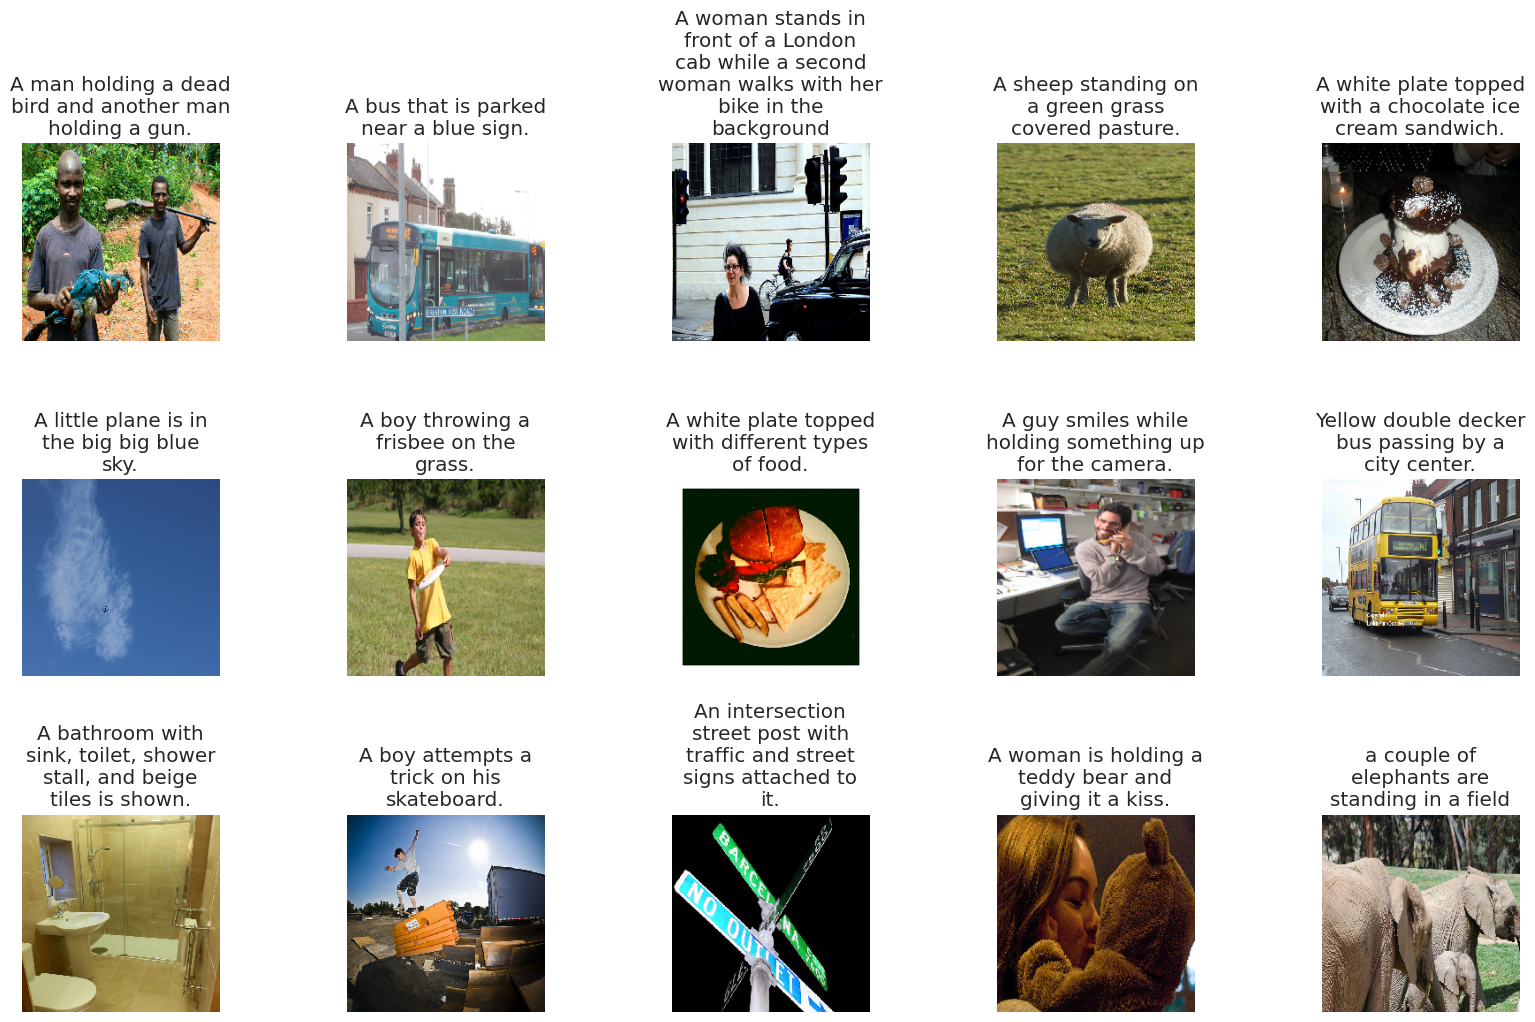

In [19]:
display_images(data_train.sample(15))

In [20]:
directory_path = "/kaggle/input/coco-val2014-nb/val2014/"
file_list = os.listdir(directory_path)
# Tạo danh sách đường dẫn đầy đủ
file_list_fullpath = [os.path.join(directory_path, f) for f in file_list]
data_val = data_val[data_val["image"].isin(file_list_fullpath)]

In [21]:
# display_images(data_val.sample(15))

In [22]:
directory_path = "/kaggle/input/coco-image-caption/val2017/val2017"
file_list = os.listdir(directory_path)
# Tạo danh sách đường dẫn đầy đủ
file_list_fullpath = [os.path.join(directory_path, f) for f in file_list]
data_val_2017 = data_val_2017[data_val_2017["image"].isin(file_list_fullpath)]

In [23]:
# display_images(data_val_2017.sample(15))

# Preprocessing Captions

In [24]:
import re

In [25]:
def text_preprocessing(data):
    # 1. Chuyển về chữ thường
    s = data['caption'].str.lower()
    
    # 2. Loại bỏ ký tự không phải chữ cái (giữ khoảng trắng)
    s = s.str.replace(r'[^a-zA-Z\s]', '', regex=True)
    
    # 3. Ghép nhiều khoảng trắng liên tiếp thành 1
    s = s.str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # 4. Chỉ giữ các từ có độ dài ≥2: findall lấy ra list các từ phù hợp, sau đó join
    # s = s.str.findall(r'\b[a-zA-Z]{2,}\b').str.join(' ')
    
    # 5. Thêm startseq/endseq
    s = 'startseq ' + s + ' endseq'
    
    data['caption'] = s
    return data


In [26]:
# Giả sử bạn có 3 DataFrame: data_train, data_val, data_test
data = pd.concat([data_train, data_val, data_val_2017], ignore_index=True)

In [27]:
data

,image_id,image,caption
0,318556,/kaggle/input/coco-image-caption/train2014/tra...,A very clean and well decorated empty bathroom
1,116100,/kaggle/input/coco-image-caption/train2014/tra...,A panoramic view of a kitchen and all of its a...
2,318556,/kaggle/input/coco-image-caption/train2014/tra...,A blue and white bathroom with butterfly theme...
3,116100,/kaggle/input/coco-image-caption/train2014/tra...,A panoramic photo of a kitchen and dining room
4,379340,/kaggle/input/coco-image-caption/train2014/tra...,A graffiti-ed stop sign across the street from...
...,...,...,...
641776,9590,/kaggle/input/coco-image-caption/val2017/val20...,A group of men sipping drinks and talking at a...
641777,84664,/kaggle/input/coco-image-caption/val2017/val20...,"A plate of food with some eggs, potatoes, brea..."
641778,331569,/kaggle/input/coco-image-caption/val2017/val20...,The strawberries was sitting beside the tall g...
641779,231237,/kaggle/input/coco-image-caption/val2017/val20...,A bunch of small red flowers in a barnacle enc...


In [28]:
data = data.drop_duplicates(subset='caption', keep='first').reset_index(drop=True)

In [29]:
data

,image_id,image,caption
0,318556,/kaggle/input/coco-image-caption/train2014/tra...,A very clean and well decorated empty bathroom
1,116100,/kaggle/input/coco-image-caption/train2014/tra...,A panoramic view of a kitchen and all of its a...
2,318556,/kaggle/input/coco-image-caption/train2014/tra...,A blue and white bathroom with butterfly theme...
3,116100,/kaggle/input/coco-image-caption/train2014/tra...,A panoramic photo of a kitchen and dining room
4,379340,/kaggle/input/coco-image-caption/train2014/tra...,A graffiti-ed stop sign across the street from...
...,...,...,...
593963,401092,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,A plate of food and a beverage are on a table.
593964,401092,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,This is an open faced sandwich with several co...
593965,555904,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,People eating in a restaurant near wine bottles.
593966,6177,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,The scissors with black handles are sitting open.


In [30]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq a very clean and well decorated empty bathroom endseq',
 'startseq a panoramic view of a kitchen and all of its appliances endseq',
 'startseq a blue and white bathroom with butterfly themed wall tiles endseq',
 'startseq a panoramic photo of a kitchen and dining room endseq',
 'startseq a graffitied stop sign across the street from a red car endseq',
 'startseq a vandalized stop sign and a red beetle on the road endseq',
 'startseq a bathroom with a border of butterflies and blue paint on the walls above it endseq',
 'startseq an angled view of a beautifully decorated bathroom endseq',
 'startseq the two people are walking down the beach endseq',
 'startseq a sink and a toilet inside a small bathroom endseq']

# Tokenizer

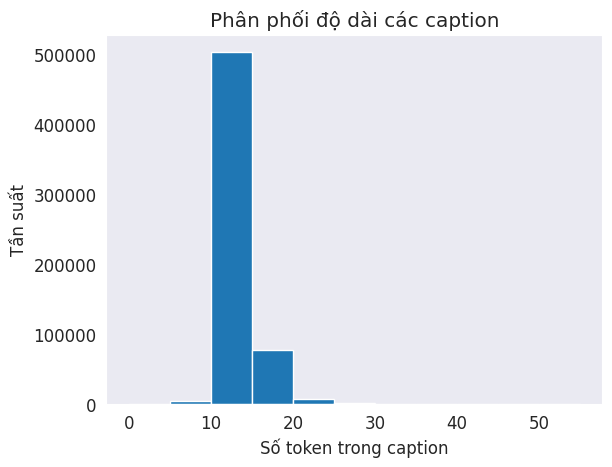

Độ dài tối đa       : 51
Percentile 90%      : 15
Percentile 95%      : 17
Percentile 99%      : 21


In [31]:
lengths = [len(c.split()) for c in captions]

# 1) Vẽ histogram
plt.hist(lengths, bins=range(0, max(lengths)+5, 5))
plt.xlabel('Số token trong caption')
plt.ylabel('Tần suất')
plt.title('Phân phối độ dài các caption')
plt.show()

# 2) In ra thống kê
print(f"Độ dài tối đa       : {max(lengths)}")
print(f"Percentile 90%      : {int(np.percentile(lengths, 90))}")
print(f"Percentile 95%      : {int(np.percentile(lengths, 95))}")
print(f"Percentile 99%      : {int(np.percentile(lengths, 99))}")

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = 20

In [33]:
tokenizer.texts_to_sequences([captions[1]])[0]

[2, 1, 3855, 160, 5, 1, 60, 9, 311, 5, 106, 613, 3]

In [34]:
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json

# ── LƯU ──────────────────────────────
token_json = tokenizer.to_json()      # string JSON
with open("tokenizer.json", "w", encoding="utf-8") as f:
    f.write(token_json)

In [35]:
# Đọc chuỗi JSON từ file
with open("tokenizer.json", "r", encoding="utf-8") as f:
    json_str = f.read()

# Tạo lại tokenizer từ chuỗi JSON
tokenizer = tokenizer_from_json(json_str)

In [36]:
tokenizer.texts_to_sequences([captions[1]])[0]

[2, 1, 3855, 160, 5, 1, 60, 9, 311, 5, 106, 613, 3]

# Train Test Split

In [37]:
images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [38]:
train

,image_id,image,caption
0,318556,/kaggle/input/coco-image-caption/train2014/tra...,startseq a very clean and well decorated empty...
1,116100,/kaggle/input/coco-image-caption/train2014/tra...,startseq a panoramic view of a kitchen and all...
2,318556,/kaggle/input/coco-image-caption/train2014/tra...,startseq a blue and white bathroom with butter...
3,116100,/kaggle/input/coco-image-caption/train2014/tra...,startseq a panoramic photo of a kitchen and di...
4,379340,/kaggle/input/coco-image-caption/train2014/tra...,startseq a graffitied stop sign across the str...
...,...,...,...
507335,100547,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq two cheese burgers placed in a box in...
507336,329088,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq a snow skier with a red back pack som...
507337,42215,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq a book a teacup and a vase stand behi...
507338,505636,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq a snowboarder makes a jump above the ...


In [39]:
test

,image_id,image,caption
0,581253,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq a zebra grazing on some grass near a ...
1,163575,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq a man and two dogs laying on top of a...
2,331529,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq a woman seated near buckets and baske...
3,400062,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq a man in brown shirt playing with a r...
4,12166,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq a couple of horses grazing in a grass...
...,...,...,...
86623,401092,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq a plate of food and a beverage are on...
86624,401092,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq this is an open faced sandwich with s...
86625,555904,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq people eating in a restaurant near wi...
86626,6177,/kaggle/input/coco-val2014-nb/val2014/COCO_val...,startseq the scissors with black handles are s...


# Load Features

In [40]:
import pickle

with open('/kaggle/input/features-train2014-val2017-coco/features_train2014_val_2017/features_train.pkl', 'rb') as f:
    features_train = pickle.load(f)

with open('/kaggle/input/extract-features-val2014coco/features_val_2014.pkl', 'rb') as f:
    features_val = pickle.load(f)

with open('/kaggle/input/features-train2014-val2017-coco/features_train2014_val_2017/features_val.pkl', 'rb') as f:
    features_val_2017 = pickle.load(f)

In [41]:
features_all = {}
features_all.update(features_train)
features_all.update(features_val)
features_all.update(features_val_2017)

In [42]:
preview = []
for fname, feat in list(features_all.items())[:10]:  # lấy 10 dòng
    preview.append({
        'filename': fname,
        'shape': feat.shape,
        'sample_flat_5': feat.flatten()[:5]
    })

df_preview = pd.DataFrame(preview)
print(df_preview)

                          filename        shape  \
0  COCO_train2014_000000318556.jpg  (7, 7, 512)   
1  COCO_train2014_000000116100.jpg  (7, 7, 512)   
2  COCO_train2014_000000379340.jpg  (7, 7, 512)   
3  COCO_train2014_000000134754.jpg  (7, 7, 512)   
4  COCO_train2014_000000538480.jpg  (7, 7, 512)   
5  COCO_train2014_000000476220.jpg  (7, 7, 512)   
6  COCO_train2014_000000299675.jpg  (7, 7, 512)   
7  COCO_train2014_000000032275.jpg  (7, 7, 512)   
8  COCO_train2014_000000302443.jpg  (7, 7, 512)   
9  COCO_train2014_000000025470.jpg  (7, 7, 512)   

                     sample_flat_5  
0        [0.0, 0.0, 0.0, 0.0, 0.0]  
1        [0.0, 0.0, 0.0, 0.0, 0.0]  
2        [0.0, 0.0, 0.0, 0.0, 0.0]  
3  [0.0, 0.0, 0.0, 0.0, 20.932352]  
4        [0.0, 0.0, 0.0, 0.0, 0.0]  
5        [0.0, 0.0, 0.0, 0.0, 0.0]  
6  [0.0, 0.0, 0.0, 0.0, 7.6821184]  
7  [0.0, 0.0, 0.0, 4.4360514, 0.0]  
8        [0.0, 0.0, 0.0, 0.0, 0.0]  
9        [0.0, 0.0, 0.0, 0.0, 0.0]  


In [43]:
for k, feat in features_all.items():
    arr = np.array(feat)
    # Nếu có batch dim thừa ở đầu, loại bỏ nó
    if arr.ndim == 4 and arr.shape[0] == 1:
        arr = arr.squeeze(0)            # (7,7,512)
    # Bây giờ arr.ndim == 3
    if arr.ndim == 3:
        H, W, C = arr.shape             # H=W=7, C=512
        arr = arr.reshape(H*W, C)       # → (49,512)
    elif arr.ndim == 2:
        # Nếu đã là (49,512) thì giữ nguyên
        assert arr.shape[0] * arr.shape[1] == 49*C
    else:
        raise ValueError(f"Unsupported feature shape {arr.shape}")
    features_all[k] = arr.astype(np.float16)

In [44]:
sample = next(iter(features_all.values()))
print("New feature shape:", sample.shape) 

New feature shape: (49, 512)


In [45]:
import gc
gc.collect()

38580

# Create Data Loader In Model

In [46]:
class CaptionDataLoader(Sequence):
    """
    Sequence data loader for Image Captioning.

    Yields:
      X = [img_feats, cap_input]  
         img_feats: (B, num_patches, feature_dim)  
         cap_input: (B, max_len)  
      y = cap_target  
         cap_target: (B, max_len)  — token ids shifted by one  
    """
    def __init__(self, df, img_col, cap_col,
                 tokenizer, features_dict,
                 max_len, batch_size=64, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.img_col = img_col
        self.cap_col = cap_col
        self.tokenizer = tokenizer
        self.features = features_dict
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Precompute token sequences
        self.seqs = tokenizer.texts_to_sequences(self.df[self.cap_col])
        # Pad all sequences to max_len
        self.seqs = tf.keras.preprocessing.sequence.pad_sequences(
            self.seqs, maxlen=self.max_len, padding='post'
        )
        self.indices = np.arange(len(self.seqs))
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.indices) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        # Batch slice
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        B = len(batch_idx)

        # Prepare containers
        num_patches, feat_dim = next(iter(self.features.values())).shape
        img_batch = np.zeros((B, num_patches, feat_dim), dtype=np.float32)
        cap_in    = np.zeros((B, self.max_len), dtype=np.int32)
        cap_tar   = np.zeros((B, self.max_len), dtype=np.int32)

        for i, j in enumerate(batch_idx):
            # 1) load image features
            fname = os.path.basename(self.df.loc[j, self.img_col])
            img_batch[i] = self.features[fname]

            # 2) get full padded sequence
            seq = self.seqs[j]
            # input is full seq, target is shifted left by 1
            cap_in[i]  = seq
            cap_tar[i] = np.concatenate([seq[1:], [0]])  # shift and pad last

        return {"img_map": img_batch, "cap_input": cap_in}, cap_tar

# Build Model

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, callbacks

In [48]:
# ===== Custom Layers =====
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim)
        self.embed_dim = embed_dim
        self.sequence_length = sequence_length
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        x = self.token_embeddings(inputs)
        x *= self.embed_scale
        positions = tf.range(start=0, limit=seq_len, delta=1)
        pos_emb = self.position_embeddings(positions)
        return x + pos_emb[tf.newaxis, ...]

    def compute_mask(self, inputs, mask=None):
        # return tf.not_equal(inputs, 0)
         return inputs != 0

In [49]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=None, mask=None):
        # Self-attention
        attn_out = self.attn(query=inputs, value=inputs, key=inputs, attention_mask=mask)
        attn_out = self.dropout1(attn_out, training=training)
        out1 = self.norm1(inputs + attn_out)
        # Feed-forward
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out, training=training)
        return self.norm2(out1 + ffn_out)

In [50]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.self_attn = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.cross_attn = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)

    def create_look_ahead_mask(self, seq_len):
        # allow positions <= current, mask future
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return tf.cast(mask, tf.bool)  # shape (seq_len, seq_len), tf.newaxis, ...]

    def call(self, x, enc_output,
             training=None,
             look_ahead_mask=None,    # <- nhận vào nhưng sẽ bỏ qua
             padding_mask=None       # <- cũng nhận vào nhưng bỏ qua
            ):
        # 1) tự sinh causal mask
        seq_len = tf.shape(x)[1]
        causal_mask = self.create_look_ahead_mask(seq_len)

        # 2) Masked self-attention
        attn1 = self.self_attn(
            query=x, value=x, key=x,attention_mask=causal_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.norm1(x + attn1)

        # 3) Cross-attention (no mask)
        attn2 = self.cross_attn(query=out1, value=enc_output, key=enc_output)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.norm2(out1 + attn2)

        # 4) Feed-forward
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out, training=training)
        return self.norm3(out2 + ffn_out)

In [51]:
# ===== Build Model =====
def build_image_captioning_model(
    feature_dim, num_patches,
    vocab_size, max_len,
    num_layers=4,
    embed_dim=512, num_heads=8,
    ff_dim=2048, dropout_rate=0.1
):
    # image feature input & projection
    img_input = layers.Input(shape=(num_patches, feature_dim), name='img_input')
    proj = layers.Dense(embed_dim, activation='relu')(img_input)
    # learned patch positional embedding
    pos_layer = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)
    positions = tf.range(num_patches)
    proj += pos_layer(positions)[tf.newaxis, ...]
    # encoder
    x_enc = proj
    for _ in range(num_layers):
        x_enc = TransformerEncoderBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x_enc, training=True)
    enc_output = x_enc

    # caption input & embedding
    cap_input = layers.Input(shape=(max_len,), name='cap_input')
    cap_emb = PositionalEmbedding(max_len, vocab_size, embed_dim)(cap_input)
    look_mask = TransformerDecoderBlock(embed_dim, num_heads, ff_dim).create_look_ahead_mask(max_len)
    # decoder
    x_dec = cap_emb
    for _ in range(num_layers):
        x_dec = TransformerDecoderBlock(embed_dim, num_heads, ff_dim, dropout_rate)(
            x_dec, enc_output, training=True, look_ahead_mask=look_mask)
    # output
    outputs = layers.Dense(vocab_size, activation='softmax')(x_dec)
    return Model(inputs={"img_map": img_input, "cap_input": cap_input}, outputs=outputs)

In [52]:
# ===== Example =====
FEATURE_DIM = 512
NUM_PATCHES = 49
VOCAB_SIZE  = vocab_size
MAX_LEN     = max_length
model = build_image_captioning_model(
    FEATURE_DIM, NUM_PATCHES,
    VOCAB_SIZE, MAX_LEN,
    num_layers=2, embed_dim=512,
    num_heads=4, ff_dim=2048,
    dropout_rate=0.1
)
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()

I0000 00:00:1747258405.847193      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747258405.849473      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)    │ (None, 49, 512)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 49, 512)        │        262,656 │ img_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 49, 512)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cap_input (InputLayer)    │ (None, 20)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_block │ (None, 49, 512)        │      6,302,720 │ add[0][0]              │
│ (TransformerEncoderBlock) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding      │ (None, 20, 512)        │     14,901,248 │ cap_input[0][0]        │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_bloc… │ (None, 49, 512)        │      6,302,720 │ transformer_encoder_b… │
│ (TransformerEncoderBlock) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_bloc… │ (None, 20, 512)        │     10,504,704 │ positional_embedding[… │
│ (TransformerDecoderBlock) │                        │                │ transformer_encoder_b… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_bloc… │ (None, 20, 512)        │     10,504,704 │ transformer_decoder_b… │
│ (TransformerDecoderBlock) │                        │                │ transformer_encoder_b… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 20, 29084)      │     14,920,092 │ transformer_decoder_b… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 63,698,844 (242.99 MB)

 Trainable params: 63,698,844 (242.99 MB)

 Non-trainable params: 0 (0.00 B)

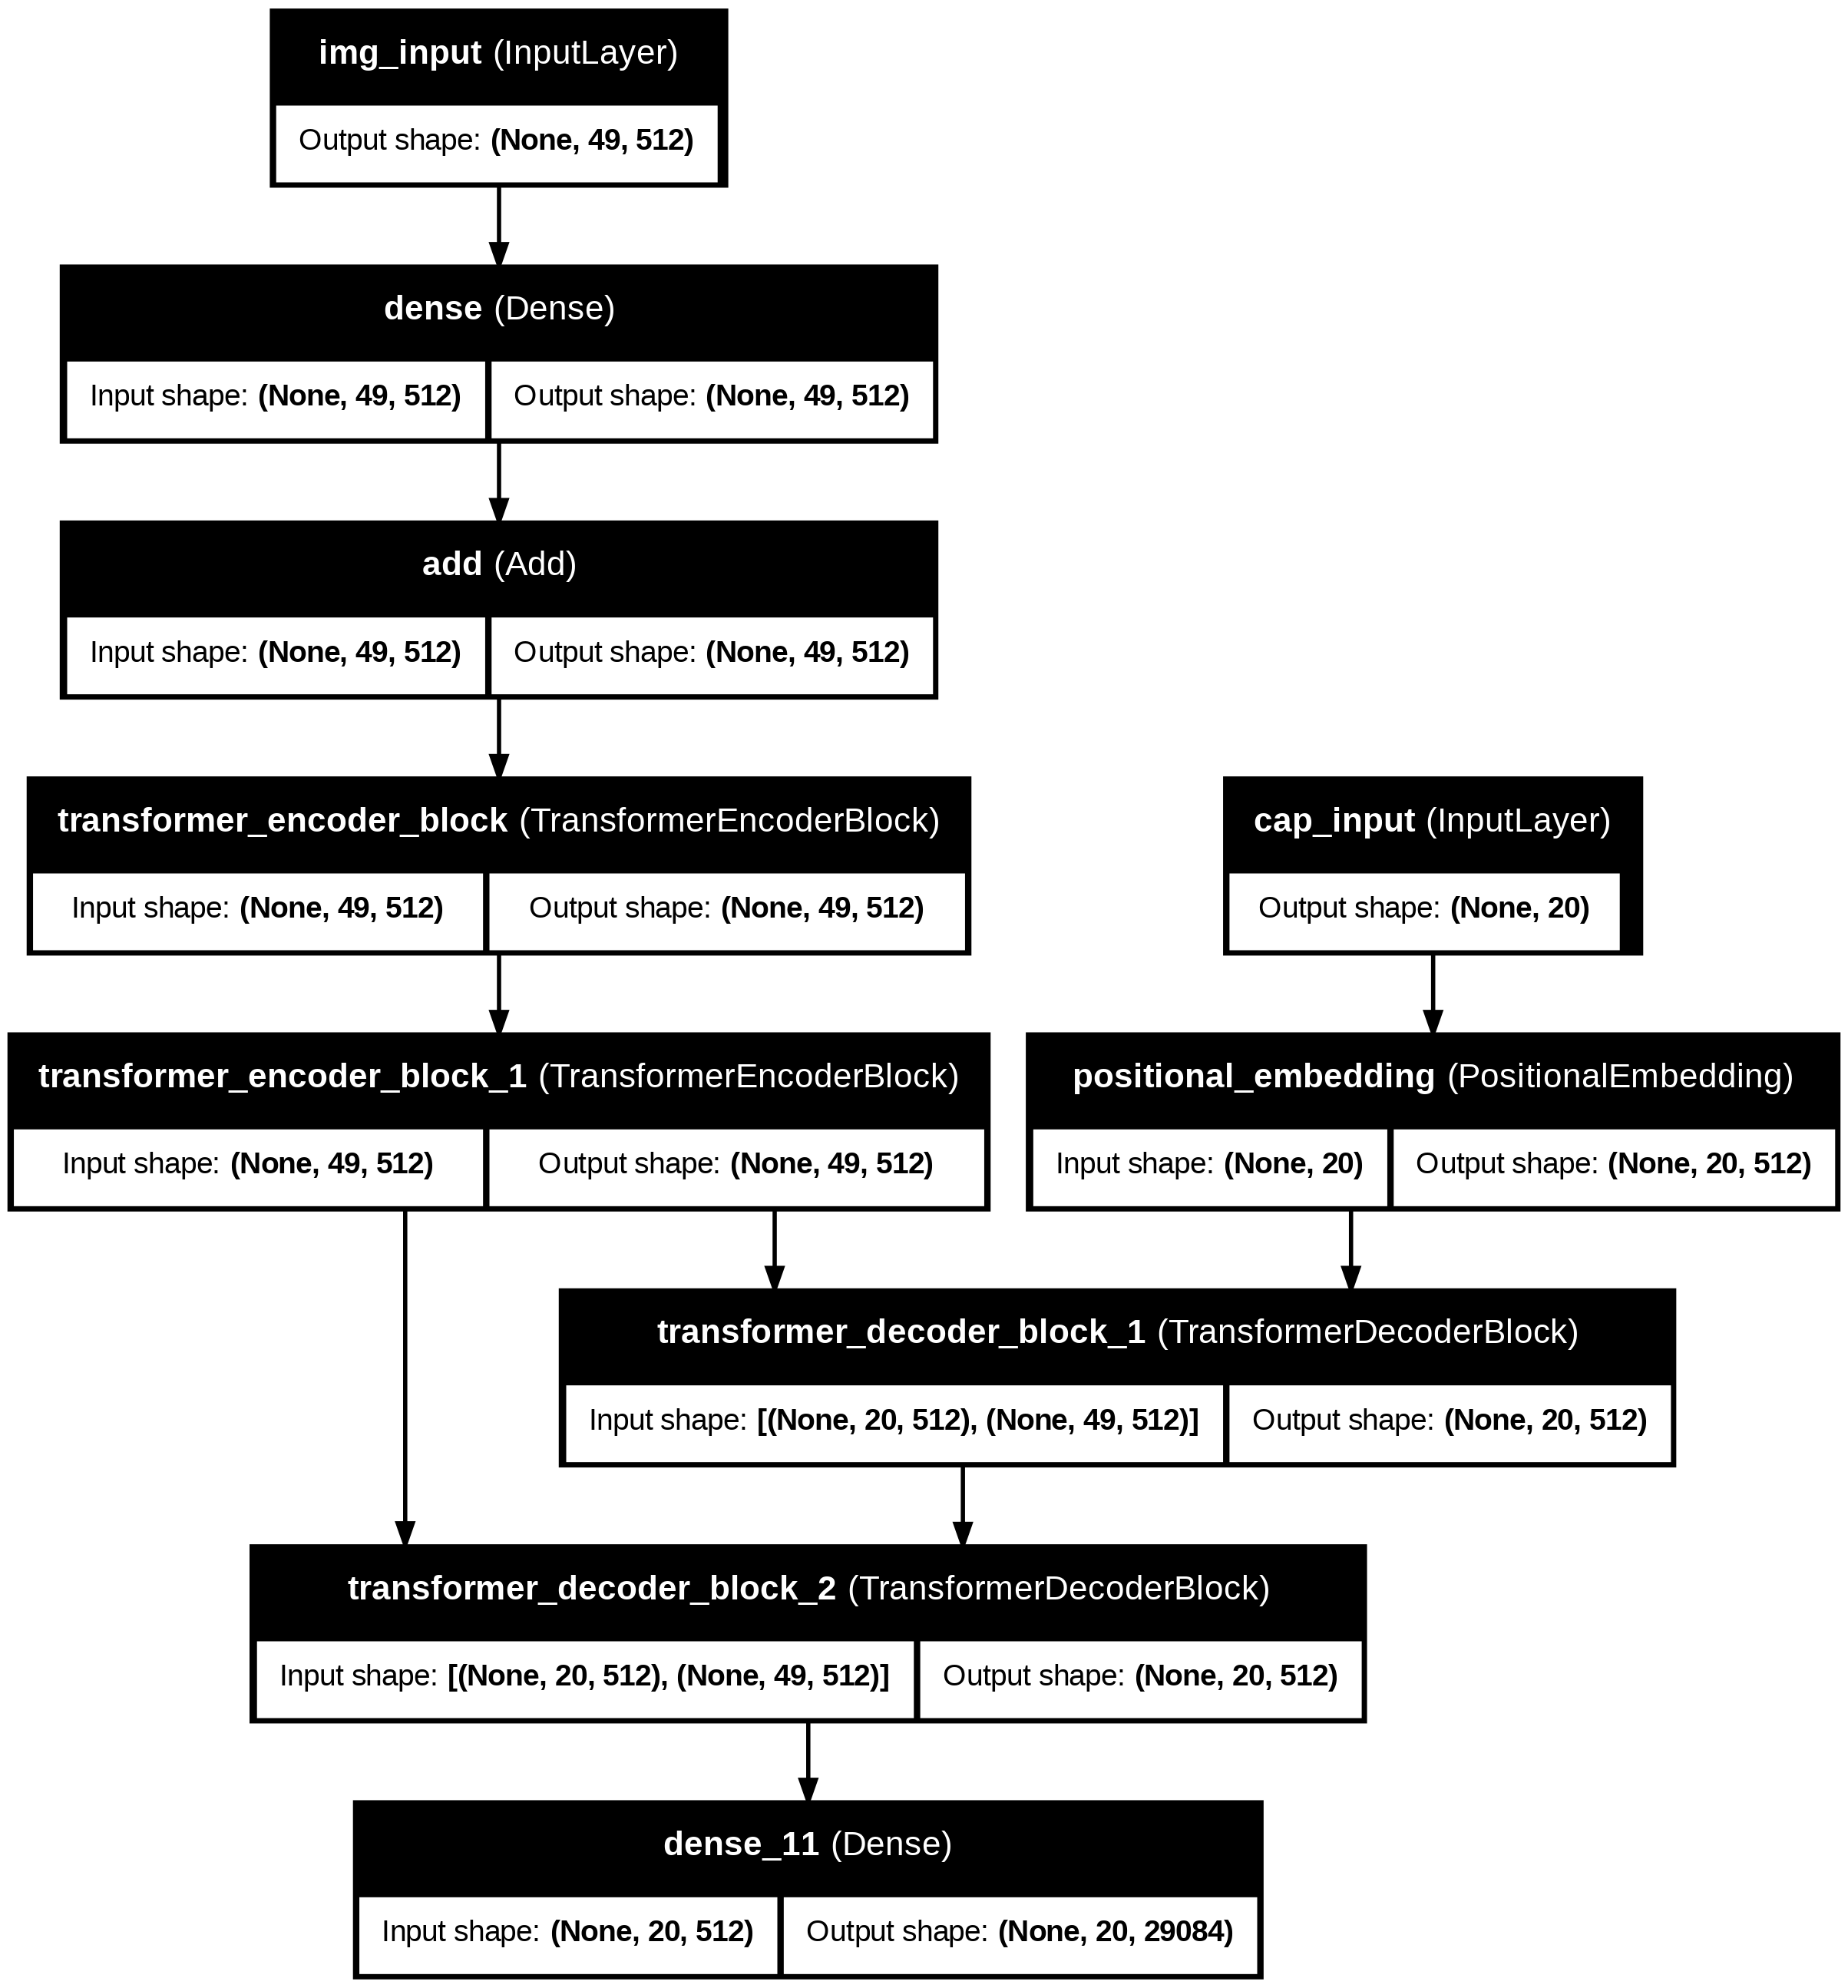

In [53]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,  # nếu bạn có nested Model
)

# Checkpoint

In [54]:
model_name = "caption_inceptionv3_trans.keras"     # đặt tên lại cho sát kiến trúc

checkpoint = ModelCheckpoint(
    filepath=model_name,            # lưu dưới dạng SavedModel *.keras
    monitor="val_loss",             # giữ best theo loss (hoặc metric tuỳ bạn)
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          # dừng sau 3 epoch không tiến bộ
    min_delta=0.0,
    restore_best_weights=True,
    verbose=1
)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

# Train Model

In [55]:
# 1) Tạo loader cho train và validation
train_caption_data_loader = CaptionDataLoader(
    df=train,
    img_col='image',
    cap_col='caption',
    tokenizer=tokenizer,
    features_dict=features_all,
    max_len=max_length,
    batch_size=64,
    shuffle=True
)

val_caption_data_loader = CaptionDataLoader(
    df=test,
    img_col='image',
    cap_col='caption',
    tokenizer=tokenizer,
    features_dict=features_all,
    max_len=max_length,
    batch_size=64,
    shuffle=False
)

In [56]:
# 2) Train + đánh giá
model.fit(
    train_caption_data_loader,
    validation_data=val_caption_data_loader,
    epochs=20,
    callbacks=[checkpoint,earlystopping,learning_rate_reduction]
)

Epoch 1/20


I0000 00:00:1747258440.952922      65 service.cc:148] XLA service 0x7ac01400ee00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747258440.955008      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747258440.955034      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1747258442.246808      65 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1747258443.127410      65 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747258459.503623      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1590/7928 ━━━━━━━━━━━━━━━━━━━━ 37:39 357ms/step - loss: 3.2517 - sparse_categorical_accuracy: 0.5830

W0000 00:00:1747259027.317999      65 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


7928/7928 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 2.1913 - sparse_categorical_accuracy: 0.6465

W0000 00:00:1747261334.730047      65 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1747261432.071189      65 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 1.47555, saving model to caption_inceptionv3_trans.keras
7928/7928 ━━━━━━━━━━━━━━━━━━━━ 3021s 376ms/step - loss: 2.1912 - sparse_categorical_accuracy: 0.6465 - val_loss: 1.4756 - val_sparse_categorical_accuracy: 0.6990 - learning_rate: 1.0000e-04
Epoch 2/20
7928/7928 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 1.3860 - sparse_categorical_accuracy: 0.7085
Epoch 2: val_loss improved from 1.47555 to 1.40603, saving model to caption_inceptionv3_trans.keras
7928/7928 ━━━━━━━━━━━━━━━━━━━━ 2962s 374ms/step - loss: 1.3860 - sparse_categorical_accuracy: 0.7085 - val_loss: 1.4060 - val_sparse_categorical_accuracy: 0.7061 - learning_rate: 1.0000e-04
Epoch 3/20
7928/7928 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 1.2728 - sparse_categorical_accuracy: 0.7213
Epoch 3: val_loss improved from 1.40603 to 1.38437, saving model to caption_inceptionv3_trans.keras
7928/7928 ━━━━━━━━━━━━━━━━━━━━ 2961s 373ms/step - loss: 1.2728 - sparse_categorical_accuracy: 0.7213 - va

# Genarative Caption

In [57]:
def greedy_decode(model, feature, tokenizer, max_len):
    """
    Generate caption for an image feature using greedy search.
    feature: np.array shape (1, num_patches, feature_dim)
    returns: generated caption string
    """
    in_seq = [tokenizer.word_index['startseq']]
    for i in range(max_len):
        seq_padded = pad_sequences([in_seq], maxlen=max_len, padding='post')
        
        # Predict next token probabilities
        yhat = model.predict({"img_map": feature, "cap_input": seq_padded}, verbose=0)
        probs = yhat[0, len(in_seq)-1]
        next_token = np.argmax(probs)
        in_seq.append(int(next_token))
        print(in_seq)
        if next_token == tokenizer.word_index.get('endseq'):
            break
    # convert tokens to words
    words = [tokenizer.index_word[idx] for idx in in_seq if idx not in (tokenizer.word_index['startseq'], tokenizer.word_index['endseq'], 0)]
    return ' '.join(words)

In [58]:
def beam_search_decode(model, feature, tokenizer, max_len, beam_width=3):
    """
    Generate caption for an image feature using beam search.
    feature: np.array shape (1, num_patches, feature_dim)
    returns: best caption string
    """
    start = tokenizer.word_index['startseq']
    end = tokenizer.word_index['endseq']
    # Initialize sequences [(seq, score)]
    sequences = [([start], 0.0)]
    for _ in range(max_len):
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == end:
                # already finished
                all_candidates.append((seq, score))
                continue
            seq_padded = pad_sequences([seq], maxlen=max_len, padding='post')
            yhat = model.predict({"img_map": feature, "cap_input": seq_padded}, verbose=0)
            probs = yhat[0, len(seq)-1]
            # select top beam_width candidates
            top_tokens = np.argsort(probs)[-beam_width:]
            for token in top_tokens:
                cand_seq = seq + [int(token)]
                cand_score = score - np.log(probs[token] + 1e-10)
                all_candidates.append((cand_seq, cand_score))
        # order by score
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]
    # choose best sequence
    best_seq = sequences[0][0]
    # convert tokens to words
    words = [tokenizer.index_word[idx] for idx in best_seq if idx not in (start, end, 0)]
    return ' '.join(words)

# Eval On Test

In [59]:
from nltk.translate.bleu_score import corpus_bleu

# 1) Chuẩn bị danh sách ảnh và ground‐truth captions
image_ids = test['image'].unique().tolist()[:1000]

# Mỗi phần tử của refs là 1 list các reference captions (tách token) cho 1 ảnh
refs = []
for img in image_ids:
    caps = test[test['image'] == img]['caption'].tolist()
    # Loại bỏ startseq/endseq và split
    caps_tok = [cap.replace('startseq ', '').replace(' endseq', '').split() for cap in caps]
    refs.append(caps_tok)

# 2) Sinh caption cho mỗi ảnh
hyp_greedy = []
hyp_beam   = []
for img in image_ids:
    # Lấy feature và reshape thành (1, num_patches, feat_dim)
    feat = features[os.path.basename(img)][None, ...]
    
    # Greedy
    cap_g = greedy_decode(model, feat, tokenizer, max_length)
    hyp_greedy.append(cap_g.split())
    
    # Beam Search
    cap_b = beam_search_decode(model, feat, tokenizer, max_length, beam_width=5)
    hyp_beam.append(cap_b.split())

# 3) Tính BLEU-4
bleu_greedy = corpus_bleu(refs, hyp_greedy, weights=(0.25,0.25,0.25,0.25))
bleu_beam   = corpus_bleu(refs, hyp_beam,   weights=(0.25,0.25,0.25,0.25))

print(f"BLEU-4 (Greedy)    = {bleu_greedy:.4f}")
print(f"BLEU-4 (Beam, k=5) = {bleu_beam:.4f}")

NameError: name 'features' is not defined